# Практическая работа 6

## Двухуровневые модели рекомендаций.

Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics_v2 import precision_at_k, recall_at_k
from src.utils_v2 import prefilter_items
from src.recommenders_v2 import MainRecommender

In [8]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [9]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [97]:
recommender = MainRecommender(data_train_lvl_1)

In [173]:
# recommender.get_als_recommendations(2375, N=200)

In [174]:
# recommender.get_own_recommendations(2375, N=200)

In [175]:
# recommender.get_similar_items_recommendation(2375, N=200)

In [176]:
# recommender.get_similar_users_recommendation(2375, N=200)

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [15]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [21]:
# your_code

N = 200
hot_users = data_train_lvl_1['user_id'].unique().tolist()
top_popular = recommender.overall_top_purchases[:N]

Для новых пользователей будем рекомендовать топ популярных товаров. 

In [30]:
%%time

result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=N) if x in hot_users else top_popular)

CPU times: user 1min 43s, sys: 1min 30s, total: 3min 14s
Wall time: 25.2 s


In [31]:
%%time

result_lvl_1['self'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N) if x in hot_users else top_popular)

CPU times: user 6.07 s, sys: 316 ms, total: 6.38 s
Wall time: 5.83 s


In [32]:
%%time

result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N) if x in hot_users else top_popular)

CPU times: user 3min 45s, sys: 3min 14s, total: 6min 59s
Wall time: 54.3 s


In [170]:
%%time

# result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=N) if x in hot_users else top_popular)

CPU times: user 8 µs, sys: 7 µs, total: 15 µs
Wall time: 26.9 µs


In [171]:
result_lvl_1['combined'] = result_lvl_1['user_id'].apply(lambda x: \
    result_lvl_1.loc[result_lvl_1.user_id == x]['als'].tolist()[0][0:66] + \
    result_lvl_1.loc[result_lvl_1.user_id == x]['self'].tolist()[0][0:67] + \
    result_lvl_1.loc[result_lvl_1.user_id == x]['similar_items'].tolist()[0][0:67])

In [172]:
result_lvl_1.head()

,user_id,actual,als,self,similar_items,combined
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1084310, 9526630, 847962, 856942, 883616, 952...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[921763, 1007512, 9297615, 5577022, 907002, 98...","[1084310, 9526630, 847962, 856942, 883616, 952..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[5569230, 1041796, 5569845, 1045586, 1104414, ...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[5569230, 1041796, 5569845, 1045586, 1104414, ..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[987044, 8090521, 982790, 891423, 1137010, 936...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[869322, 861279, 1128539, 999714, 958208, 7024...","[987044, 8090521, 982790, 891423, 1137010, 936..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[965267, 896613, 878996, 1026118, 1051516, 871...","[13003092, 972416, 995598, 923600, 1138596, 10...","[948650, 5569845, 8357613, 941361, 1074754, 11...","[965267, 896613, 878996, 1026118, 1051516, 871..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[839419, 1098694, 1041688, 5981267, 871513, 11...","[998519, 894360, 7147142, 9338009, 896666, 939...","[917816, 1044078, 949023, 995478, 861246, 9656...","[839419, 1098694, 1041688, 5981267, 871513, 11..."


Посчитаем полноту различных рекомендаций.

In [181]:
def average_recall_at_k(recommended_matrix, bought_matrix, k=5):
    
    rows_count = bought_matrix.shape[0]
    recall_by_row = [recall_at_k(recommended_matrix[i], bought_matrix[i], k) for i in range(rows_count)]
    recall_mean = np.mean(recall_by_row)

    return recall_mean

In [182]:
columns = result_lvl_1.columns.drop(['user_id', 'actual'])

for column in columns:
    recall_mean = average_recall_at_k(result_lvl_1[column], result_lvl_1.actual, k=200)
    print('{:35} {:.4f} %'.format(column, recall_mean * 100))

als                                 9.7261 %
self                                13.5282 %
similar_items                       8.4794 %
combined                            11.6629 %


Лучший результат дает сочетание рекомендации собственных покупок и топ популярных покупок. 

***Примечание***
Класс `MainRecommender` дополняет список рекомендаций из собственных покупок популярными товарами, если своих покупок меньше чем `K = 200`. 

In [184]:
result_lvl_1['user_id'].values

array([   1,    2,    4, ..., 2498, 2499, 2500])

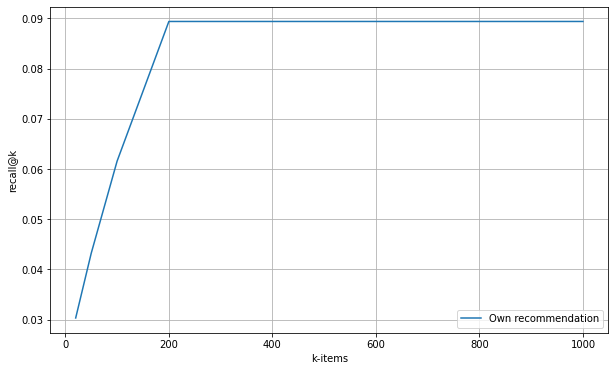

In [190]:
# Перебираемые значения K.
k_list = [20, 50, 100, 200, 300, 400, 500]

# Список для сохранения результатов.
recall_list = [] # 

# Список пользователей.
users_list = result_lvl_1['user_id'].values

for k in k_list:
    own_recs = []
    for user in users_list: 
        own_recs.append(recommender.get_own_recommendations(user, N=k) if x in hot_users else top_popular)
    recall_list.append(average_recall_at_k(own_recs, result_lvl_1.actual, k=k))
    

plt.figure(figsize=(10, 6))

plt.plot(k_list, recall_list, label="Own recommendation")
plt.xlabel('k-items')
plt.ylabel('recall@k')
plt.legend()
plt.grid()
plt.show()

Значение метрики перестает расти, если $K > 200$. Скорее всего это связано с тем что в среднем из валидационного датасета пользователи покупают 12 товаров. При $K = 200$ все купленные товары попадают в число рекомендованных.

Думаю что для модели первого уровня выбирать $K = 200$ вполне обосновано.

In [201]:
np.unique(data_val_lvl_1.item_id.values).size / np.unique(data_val_lvl_1.user_id.values).size

12.836118848653667

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [ ]:
# your_code